# <center> Sending and receiving a pulse demonstration

### <center> In this demo you will send and receive a pulse in loopback to demonstrate control over the QICK. 

By modifying the <code> config </code> Python dictionary in the below notebook cell, you can change several variables:
* The pulse length <code> length </code> in FPGA clock ticks (1 clock tick = 2.6 ns).
* The readout buffer length <code> readout_length </code> in FPGA clock ticks.
* The pulse envelope shape <code> pulse_style </code> (either <code> const </code> or <code> flat_top </code> or <code> arb </code>)
* The pulse amplitude <code> pulse_gain </code> in DAC units.
* The pulse frequency <code> pulse_freq </code> in MHz.
* The readout "time of flight" <code> adc_trig_offset </code> in FPGA clock ticks.
* The number of times you average the read <code> soft_avgs </code>

In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load bitstream with custom overlay
# soc = QickSoc()
# soc = QickSoc(bitfile="q3diamond.bit", force_init_clks=True)
soc = QickSoc(bitfile="q3diamond.bit")
# soc = QickSoc(bitfile="../../qick-amo/pynq/qick-amo.bit")

# Since we're running locally on the QICK, we don't need a separate QickConfig object.
# If running remotely, you could generate a QickConfig from the QickSoc:
#     soccfg = QickConfig(soc.get_cfg())
# or save the config to file, and load it later:
#     with open("qick_config.json", "w") as f:
#         f.write(soc.dump_cfg())
#     soccfg = QickConfig("qick_config.json")
soccfg = soc
print(soccfg)



QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	7 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, switch ch 0, maxlen 4096
		DAC tile 2, ch 0, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	1:	axis_sg_int4_v1 - tProc output 1, switch ch 1, maxlen 4096
		DAC tile 2, ch 1, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	2:	axis_sg_int4_v1 - tProc output 2, switch ch 2, maxlen 4096
		DAC tile 2, ch 2, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	3:	axis_sg_int4_v1 - tProc output 3, switch ch 3, maxlen 4096
		DAC tile 2, ch 3, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	4:	axis_signal_gen_v6 - tProc output 4, switch ch 4, maxlen 65536
		DAC tile 3, ch 0, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	5:	axis_signal_gen_v6 - tProc output 5, switch ch 5, maxlen 65536
		DAC tile 3, ch 1, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	6:	axis_sg_mux4_v2 - tProc output 6, switch ch -1, maxlen 0
		DAC tile 0,

### misc
you don't have to run these three cells, they are just to demonstrate ways of directly accessing the readout and gen objects.

In [ ]:
for gen in soc.gens:
    print(gen)
    if gen.HAS_MIXER:
        print(gen.get_mixer_freq())
    if hasattr(gen, 'get_freq'):
        print([gen.get_freq(i) for i in range(4)])

In [ ]:
soc.tproc.single_write(0,2**32)
print(soc.tproc.single_read(0))

In [ ]:
for ro in soc.readouts:
    print(ro.get_freq())

In [ ]:
for iq in soc.iqs:
    iq.set_iq(0,0)
    iq.set_mixer_freq(0)

### Waveform signal generators (signal_gen, sg_int4)
In these demos you can set res_ch to any signal generator that supports waveforms - either a signal_gen or an sg_int4.
If you use an sg_int4, you could also set the mixer_freq to a nonzero value.



In [ ]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]
        self.declare_gen(ch=res_ch, nqz=2, mixer_freq=cfg["mixer_freq"], ro_ch=cfg["ro_chs"][0])

        #configure the readout lengths and downconversion frequencies
        for ro_ch in cfg["ro_chs"]:
            self.declare_readout(ch=ro_ch, freq=cfg["pulse_freq"], length=cfg["readout_length"], gen_ch=cfg["res_ch"])
        
        style=self.cfg["pulse_style"]
        freq=self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])  # convert frequency to dac frequency (ensuring it is an available adc frequency)
        phase=self.deg2reg(cfg["res_phase"],gen_ch=res_ch)
        print("generator freq:", self.reg2freq(freq, gen_ch=res_ch))
        
        if style in ["flat_top","arb"]:
            sigma = cfg["sigma"]
            self.add_gauss(ch=res_ch, name="measure", sigma=sigma, length=5*sigma)
        if style == "const":
            self.set_pulse_registers(ch=res_ch, style=style, freq=freq, phase=phase, gain=cfg["pulse_gain"], length=cfg["length"],mode='periodic')
        elif style == "flat_top":
            self.set_pulse_registers(ch=res_ch, style=style, freq=freq, phase=phase, gain=cfg["pulse_gain"], waveform="measure", length=cfg["length"])
        elif style == "arb":
            self.set_pulse_registers(ch=res_ch, style=style, freq=freq, phase=phase, gain=cfg["pulse_gain"], waveform="measure")
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.measure(pulse_ch=self.cfg["res_ch"], 
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"],
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))

### Send/receive a pulse with <code> pulse_style </code> = <code> const </code>

In [ ]:
config={"res_ch":4, # --Fixed
        "mixer_freq":0.0, # MHz
        "ro_chs":[0], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":10, # --Fixed
        "res_phase":0, # --Fixed
        "pulse_style": "const", # --Fixed
        
        "length":50, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":200, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":2**15-2, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 6500, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages

       }

###################
# Try it yourself !
###################

prog =LoopbackProgram(soccfg, config)
soc.reset_gens() # clear any DC or periodic values on generators
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)
# print(prog)

### Send/receive a pulse with <code> pulse_style </code> = <code> flat_top </code>

In [ ]:
config={"res_ch":0, # --Fixed
        "mixer_freq":0.0, # MHz
        "ro_chs":[0], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1, # --Fixed
        "res_phase":0, # --Fixed
        "pulse_style": "flat_top", # --Fixed
        "length": 50, # [Clock ticks]
        # Try varying  length from 10-100 clock ticks
        "sigma": 30, # [Clock ticks]
        # Try varying sigma from 10-50 clock ticks
        
        "readout_length":200, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":30000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages

       }

# The first half of idata ramps up the flat_top pulse, the second half ramps down the flat_top pulse

###################
# Try it yourself !
###################

prog =LoopbackProgram(soccfg, config)
soc.reset_gens() # clear any DC or periodic values on generators
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)
# print(prog)

### Send/receive a pulse with <code> pulse_style </code> = <code> arb </code>

In [ ]:
config={"res_ch":0, # --Fixed
        "mixer_freq":0.0, # MHz
        "ro_chs":[0], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1, # --Fixed
        "res_phase":0, # --Fixed
        "pulse_style": "arb", # --Fixed
        
        "sigma": 30, # [Clock ticks]
        # Try varying sigma from 10-50 clock ticks
        
        "readout_length":200, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":30000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":1
        # Try varying soft_avgs from 1 to 200 averages

       }

prog =LoopbackProgram(soccfg, config)
soc.reset_gens() # clear any DC or periodic values on generators
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)
# print(prog)

In [ ]:
# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()
# plt.savefig("images/Send_recieve_pulse_const.pdf", dpi=350)

If you don't want to set a mixer freq and just want to use the mixer to trim the generator frequency, you could use the following program instead.

Note that if you want to drive frequencies above the Nyquist limit of the generator, this is not the best way to do this - you would probably want to put a relatively low frequency on the generator and mix it up.

In [ ]:
class LoopbackProgram(AveragerProgram):
    def __init__(self,soccfg,cfg):
        super().__init__(soccfg,cfg)

    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]
#         r_freq=self.sreg(cfg["res_ch"], "freq")   #Get frequency register for res_ch
        freq=self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])  # convert frequency to dac frequency (ensuring it is an available adc frequency)
        f_gen = self.reg2freq(freq, gen_ch=res_ch)
        print("generator freq:", f_gen)
        
        if self.soccfg['gens'][res_ch]['type'] == "axis_sg_int4_v1":
            # The interpolated generator has poor frequency resolution, but it has an NCO that you can mix in.
            f_mixer = cfg["pulse_freq"]-f_gen
            self.declare_gen(ch=res_ch, nqz=1, mixer_freq=f_mixer, ro_ch=cfg["ro_chs"][0])
        else:
            self.declare_gen(ch=res_ch, nqz=1, ro_ch=cfg["ro_chs"][0])

        #configure the readout lengths and downconversion frequencies
        for ro_ch in cfg["ro_chs"]:
            self.declare_readout(ch=ro_ch, freq=cfg["pulse_freq"], length=cfg["readout_length"], gen_ch=cfg["res_ch"])
        
        style=self.cfg["pulse_style"]
        if style in ["flat_top","arb"]:
            sigma = cfg["sigma"]
            nsigma = 5
            samples_per_clock = self.soccfg['gens'][res_ch]['samps_per_clk']
            idata = helpers.gauss(mu=sigma*samples_per_clock*nsigma/2,
                                  si=sigma*samples_per_clock,
                                  length=sigma*samples_per_clock*nsigma,
                                  maxv=np.iinfo(np.int16).max-1)
            self.add_pulse(ch=res_ch, name="measure", idata=idata) 
            
        if style == "const":
            self.set_pulse_registers(ch=res_ch, style=style, freq=freq, phase=0, gain=cfg["pulse_gain"], length=cfg["length"])
        elif style == "flat_top":
            self.set_pulse_registers(ch=res_ch, style=style, freq=freq, phase=0, gain=cfg["pulse_gain"], waveform="measure", length=cfg["length"])
        elif style == "arb":
            self.set_pulse_registers(ch=res_ch, style=style, freq=freq, phase=0, gain=cfg["pulse_gain"], waveform="measure")
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.synci(200) # give processor time to get ahead of the pulses
        self.trigger(adcs=self.ro_chs,pins=[0],adc_trig_offset=self.cfg["adc_trig_offset"])  # trigger the adc acquisition
        self.pulse(ch=self.cfg["res_ch"]) # play readout pulse
        # control should wait until the readout is over
        self.waiti(0, self.cfg["adc_trig_offset"]+self.cfg["readout_length"]) 
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))  # sync all channels


### sg_mux4
This will work on both old (four non-PFB readouts) and new (one PFB readout) firmwares.
With the old firmware, you'll need a splitter to wire the gen to all the readouts.

In [3]:
class LoopbackProgram(AveragerProgram):
    def __init__(self,soccfg,cfg):
        super().__init__(soccfg,cfg)

    def initialize(self):
        cfg=self.cfg   
        self.declare_gen(ch=cfg["res_ch"], nqz=1, 
                         mixer_freq=cfg["mixer_freq"], 
                         mux_freqs=cfg["pulse_freqs"], 
                         mux_gains=cfg["pulse_gains"], 
                         ro_ch=cfg["ro_chs"][0])
        for iCh, ch in enumerate(cfg["ro_chs"]): #configure the readout lengths and downconversion frequencies
            self.declare_readout(ch=ch, freq=cfg["pulse_freqs"][iCh], length=cfg["readout_length"], gen_ch=cfg["res_ch"])

        self.set_pulse_registers(ch=cfg["res_ch"], style="const", length=cfg["length"], mask=[0,1,2,3])
        self.synci(200)  # give processor some time to configure pulses

    def body(self):
        self.synci(200) # give processor time to get ahead of the pulses
        self.trigger(adcs=self.ro_chs, pins=[0],adc_trig_offset=self.cfg["adc_trig_offset"])  # trigger the adc acquisition
        self.pulse(ch=self.cfg["res_ch"],t=0)

        # control should wait until the readout is over
        self.waiti(0, self.cfg["adc_trig_offset"]+self.cfg["readout_length"]) 
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))  # sync all channels

config={"res_ch":6, # --Fixed
        "mixer_freq":1000.0, # MHz
        "ro_chs":[0,1,2,3], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":10, # --Fixed
        "pulse_style": "const", # --Fixed
        
        "length":100, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":300, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_freqs": [100, 300, 500, 700], # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.
        
        "pulse_gains": [1.0, -0.8, 0.6, -0.4],

        "adc_trig_offset": 50, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages
       }

###################
# Try it yourself !
###################

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)
# print(prog)

  0%|          | 0/100 [00:00<?, ?it/s]

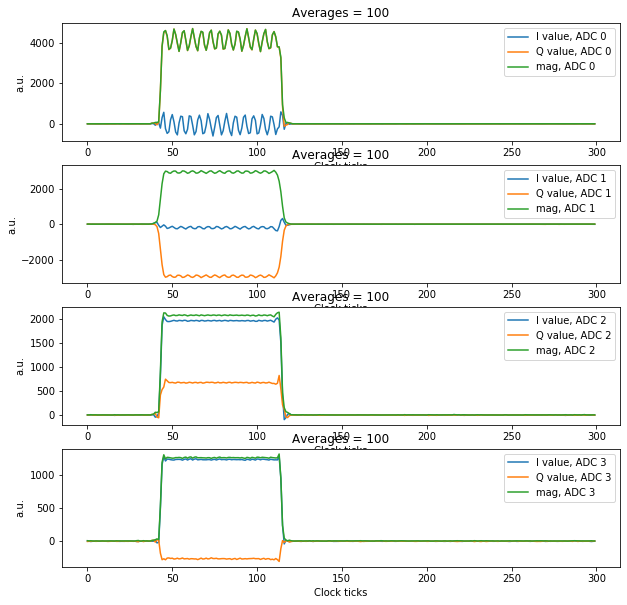

In [4]:
# Plot results.
fig, axs = plt.subplots(4,1,figsize=(10,10))

for ii, iq in enumerate(iq_list):
    plot = axs[ii]
    plot.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plot.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
    plot.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
    plot.set_ylabel("a.u.")
    plot.set_xlabel("Clock ticks")
    plot.set_title("Averages = " + str(config["soft_avgs"]))
    plot.legend()